In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ssl
import certifi
import warnings
from datetime import datetime
from textblob import TextBlob

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve, 
                             precision_recall_curve, auc)
from sklearn.utils.class_weight import compute_class_weight

In [2]:
warnings.filterwarnings('ignore')
ssl._create_default_https_context = lambda *args, **kwargs: ssl.create_default_context(cafile=certifi.where())

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/og_mel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/og_mel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/og_mel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/og_mel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df = pd.read_csv('data/ks-projects-201801.csv', parse_dates = ['deadline', 'launched'])
df

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.00


In [5]:
df.size, df.shape

(5679915, (378661, 15))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                378661 non-null  int64         
 1   name              378657 non-null  object        
 2   category          378661 non-null  object        
 3   main_category     378661 non-null  object        
 4   currency          378661 non-null  object        
 5   deadline          378661 non-null  datetime64[ns]
 6   goal              378661 non-null  float64       
 7   launched          378661 non-null  datetime64[ns]
 8   pledged           378661 non-null  float64       
 9   state             378661 non-null  object        
 10  backers           378661 non-null  int64         
 11  country           378661 non-null  object        
 12  usd pledged       374864 non-null  float64       
 13  usd_pledged_real  378661 non-null  float64       
 14  usd_

In [7]:
df.describe()

,ID,deadline,goal,launched,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,378661,3.786610e+05,378661,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,2014-11-01 16:04:27.950488832,4.908079e+04,2014-09-28 18:06:17.416520448,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
min,5.971000e+03,2009-05-03 00:00:00,1.000000e-02,1970-01-01 01:00:00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2013-06-08 00:00:00,2.000000e+03,2013-05-07 22:14:27,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,2015-01-14 00:00:00,5.200000e+03,2014-12-10 03:23:41,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,2016-04-28 00:00:00,1.600000e+04,2016-03-24 10:21:09,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,2018-03-03 00:00:00,1.000000e+08,2018-01-02 15:02:31,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08
std,6.190862e+08,NaN,1.183391e+06,NaN,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06


In [8]:
status_c = df['state'].value_counts(normalize = True)
status_c

state
failed        0.522153
successful    0.353762
canceled      0.102411
undefined     0.009407
live          0.007392
suspended     0.004875
Name: proportion, dtype: float64

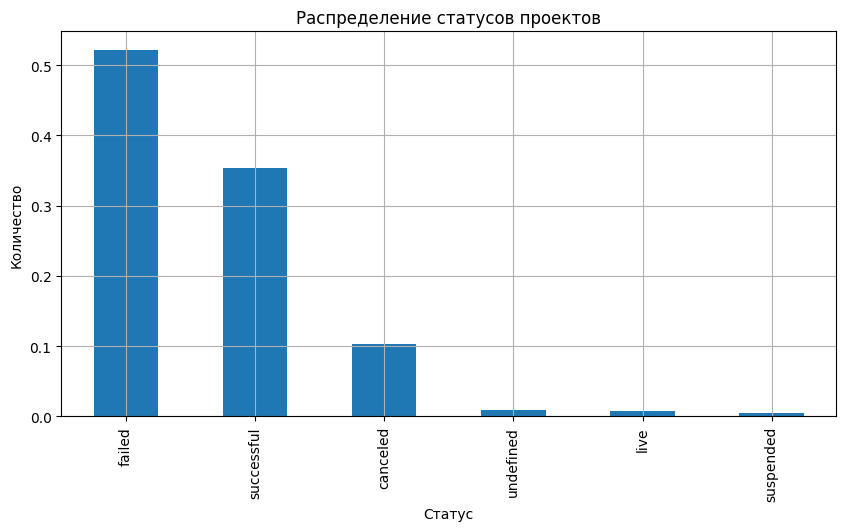

In [9]:
plt.figure(figsize = (10, 5))
status_c.plot(kind = 'bar')
plt.title('Распределение статусов проектов')
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

In [10]:
df = df[df['state'].isin(['failed', 'successful'])]
df['success'] = (df['state'] == 'successful').astype(int)
suc_rate = df['success'].mean()
suc_rate

np.float64(0.4038772895153388)

In [11]:
cols_to_drop = ['ID', 'pledged', 'usd pledged', 'state', 'backers'] # тут почти все удаляется по причине того, что информация известна после "опубликовки"
df = df.drop(columns = cols_to_drop)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331675 entries, 0 to 378660
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   name              331672 non-null  object        
 1   category          331675 non-null  object        
 2   main_category     331675 non-null  object        
 3   currency          331675 non-null  object        
 4   deadline          331675 non-null  datetime64[ns]
 5   goal              331675 non-null  float64       
 6   launched          331675 non-null  datetime64[ns]
 7   country           331675 non-null  object        
 8   usd_pledged_real  331675 non-null  float64       
 9   usd_goal_real     331675 non-null  float64       
 10  success           331675 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 30.4+ MB


In [13]:
for i in df.columns:
    print(i, df[i].isna().sum())

name 3
category 0
main_category 0
currency 0
deadline 0
goal 0
launched 0
country 0
usd_pledged_real 0
usd_goal_real 0
success 0


In [14]:
df['name'] = df['name'].fillna("Unknown")

In [15]:
df['launch_year'] = df['launched'].dt.year
df['launch_month'] = df['launched'].dt.month
df['launch_day'] = df['launched'].dt.day
df['launch_dayofweek'] = df['launched'].dt.dayofweek
df['launch_hour'] = df['launched'].dt.hour

In [16]:
df['duration_days'] = (df['deadline'] - df['launched']).dt.days
df['log_real'] = np.log1p(df['usd_goal_real'])

In [17]:
df = df.drop(columns = ['launched', 'deadline'])

In [18]:
df.head()

,name,category,main_category,currency,goal,country,usd_pledged_real,usd_goal_real,success,launch_year,launch_month,launch_day,launch_dayofweek,launch_hour,duration_days,log_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000.0,GB,0.0,1533.95,0,2015,8,11,1,12,58,7.336253
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000.0,US,2421.0,30000.00,0,2017,9,2,5,4,59,10.308986
2,Where is Hank?,Narrative Film,Film & Video,USD,45000.0,US,220.0,45000.00,0,2013,1,12,5,0,44,10.714440
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,US,1.0,5000.00,0,2012,3,17,5,3,29,8.517393
5,Monarch Espresso Bar,Restaurants,Food,USD,50000.0,US,52375.0,50000.00,1,2016,2,26,4,13,34,10.819798


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331675 entries, 0 to 378660
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              331675 non-null  object 
 1   category          331675 non-null  object 
 2   main_category     331675 non-null  object 
 3   currency          331675 non-null  object 
 4   goal              331675 non-null  float64
 5   country           331675 non-null  object 
 6   usd_pledged_real  331675 non-null  float64
 7   usd_goal_real     331675 non-null  float64
 8   success           331675 non-null  int64  
 9   launch_year       331675 non-null  int32  
 10  launch_month      331675 non-null  int32  
 11  launch_day        331675 non-null  int32  
 12  launch_dayofweek  331675 non-null  int32  
 13  launch_hour       331675 non-null  int32  
 14  duration_days     331675 non-null  int64  
 15  log_real          331675 non-null  float64
dtypes: float64(4), int32(5), 

In [20]:
df['category'].unique(), df['main_category'].unique(), df['currency'].unique(), df['country'].unique()

(array(['Poetry', 'Narrative Film', 'Music', 'Restaurants', 'Food',
        'Drinks', 'Nonfiction', 'Indie Rock', 'Crafts', 'Games',
        'Tabletop Games', 'Design', 'Comic Books', 'Art Books', 'Fashion',
        'Childrenswear', 'Theater', 'Comics', 'DIY', 'Webseries',
        'Animation', 'Food Trucks', 'Product Design', 'Public Art',
        'Documentary', 'Illustration', 'Photography', 'Pop', 'People',
        'Art', 'Family', 'Fiction', 'Film & Video', 'Accessories', 'Rock',
        'Hardware', 'Software', 'Weaving', 'Web', 'Jazz', 'Ready-to-wear',
        'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
        'Gadgets', 'Electronic Music', 'Radio & Podcasts', 'Cookbooks',
        'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
        'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
        'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
        'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
 

In [21]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [22]:
df['name_prep'] = df['name'].apply(preprocess_text)
df['name_len'] = df['name_prep'].apply(lambda x: len(x.split()))
df['name_sent'] = df['name_prep'].apply(
    lambda x: TextBlob(x).sentiment.polarity if x.strip() != '' else 0
)

In [23]:
df.head()

,name,category,main_category,currency,goal,country,usd_pledged_real,usd_goal_real,success,launch_year,launch_month,launch_day,launch_dayofweek,launch_hour,duration_days,log_real,name_prep,name_len,name_sent
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000.0,GB,0.0,1533.95,0,2015,8,11,1,12,58,7.336253,song adelaide abullah,3,0.0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000.0,US,2421.0,30000.00,0,2017,9,2,5,4,59,10.308986,greeting earth zgac art capsule et,6,0.0
2,Where is Hank?,Narrative Film,Film & Video,USD,45000.0,US,220.0,45000.00,0,2013,1,12,5,0,44,10.714440,hank,1,0.0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,US,1.0,5000.00,0,2012,3,17,5,3,29,8.517393,toshicapital rekordz need help complete album,6,0.1
5,Monarch Espresso Bar,Restaurants,Food,USD,50000.0,US,52375.0,50000.00,1,2016,2,26,4,13,34,10.819798,monarch espresso bar,3,0.0


In [24]:
df['creator_id'] = df['main_category'] + '_' + df['country']
df = df.sort_values('launch_year')
creator_history = df.groupby('creator_id').agg(
    {
        'success': ['count', 'mean'],
        'usd_goal_real': 'mean'
    }
).reset_index()

creator_history.columns = ['creator_id', 'creator_projects_count', 
                           'creator_success_rate', 'creator_avg_goal']

In [25]:
df = pd.merge(df, creator_history, on = 'creator_id', how = 'left')
df

,name,category,main_category,currency,goal,country,usd_pledged_real,usd_goal_real,success,launch_year,...,launch_hour,duration_days,log_real,name_prep,name_len,name_sent,creator_id,creator_projects_count,creator_success_rate,creator_avg_goal
0,Cherry Bomb- it's time to beat Hollywood at it...,Shorts,Film & Video,USD,6500.0,US,6844.00,6500.00,1,2009,...,20,89,8.779711,cherry bomb time beat hollywood game,6,-0.400000,Film & Video_US,46933,0.421494,72271.050943
1,Impossible Girl: Solo Record,Pop,Music,USD,20000.0,US,2975.00,20000.00,0,2009,...,19,77,9.903538,impossible girl solo record,4,-0.666667,Music_US,40225,0.539913,14292.655761
2,Have Sticks Will Travel World Tour,Sculpture,Art,USD,2500.0,US,3443.38,2500.00,1,2009,...,20,46,7.824446,stick travel world tour,4,0.000000,Art_US,20449,0.464375,32272.324104
3,High Strangeness: A 12 bit action / adventure ...,Video Games,Games,USD,1500.0,US,1559.00,1500.00,1,2009,...,22,89,7.313887,high strangeness bit action adventure video game,7,-0.046667,Games_US,20229,0.462504,43053.645051
4,First Time,Shorts,Film & Video,USD,5000.0,US,5000.00,5000.00,1,2009,...,0,88,8.517393,first time,2,0.250000,Film & Video_US,46933,0.421494,72271.050943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331670,CLEAN AIR for Utah | Local Author Book Launch,Publishing,Publishing,USD,10000.0,US,1.00,10000.00,0,2017,...,0,38,9.210440,clean air utah local author book launch,7,0.183333,Publishing_US,28677,0.347491,18567.652272
331671,Scissor Sisters SWAN SONG: A Time-Tripping Gra...,Graphic Novels,Comics,USD,3000.0,US,3206.00,3000.00,1,2017,...,0,22,8.006701,scissor sister swan song timetripping graphic ...,7,0.000000,Comics_US,8159,0.590759,23004.937896
331672,BALTIC Watches: Neo-Vintage Watches Assembled ...,Product Design,Design,EUR,65000.0,FR,575504.45,72663.86,1,2017,...,13,34,11.193613,baltic watch neovintage watch assembled france,6,0.000000,Design_FR,276,0.485507,41953.590833
331673,KoolSkinz Pet Performance Wear,Product Design,Design,USD,10000.0,US,1485.00,10000.00,0,2017,...,14,21,9.210440,koolskinz pet performance wear,4,0.000000,Design_US,18485,0.415526,39184.820769


In [26]:
for i in df.columns:
    print(i, df[i].isna().sum())

name 0
category 0
main_category 0
currency 0
goal 0
country 0
usd_pledged_real 0
usd_goal_real 0
success 0
launch_year 0
launch_month 0
launch_day 0
launch_dayofweek 0
launch_hour 0
duration_days 0
log_real 0
name_prep 0
name_len 0
name_sent 0
creator_id 0
creator_projects_count 0
creator_success_rate 0
creator_avg_goal 0


In [27]:
df = df.drop(columns = ['name', 'creator_id', 'usd_pledged_real'])

In [28]:
df = df.drop(columns = 'goal')

In [29]:
df.head()

,category,main_category,currency,country,usd_goal_real,success,launch_year,launch_month,launch_day,launch_dayofweek,launch_hour,duration_days,log_real,name_prep,name_len,name_sent,creator_projects_count,creator_success_rate,creator_avg_goal
0,Shorts,Film & Video,USD,US,6500.0,1,2009,12,14,0,20,89,8.779711,cherry bomb time beat hollywood game,6,-0.400000,46933,0.421494,72271.050943
1,Pop,Music,USD,US,20000.0,0,2009,9,14,0,19,77,9.903538,impossible girl solo record,4,-0.666667,40225,0.539913,14292.655761
2,Sculpture,Art,USD,US,2500.0,1,2009,11,5,3,20,46,7.824446,stick travel world tour,4,0.000000,20449,0.464375,32272.324104
3,Video Games,Games,USD,US,1500.0,1,2009,5,20,2,22,89,7.313887,high strangeness bit action adventure video game,7,-0.046667,20229,0.462504,43053.645051
4,Shorts,Film & Video,USD,US,5000.0,1,2009,7,21,1,0,88,8.517393,first time,2,0.250000,46933,0.421494,72271.050943


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331675 entries, 0 to 331674
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   category                331675 non-null  object 
 1   main_category           331675 non-null  object 
 2   currency                331675 non-null  object 
 3   country                 331675 non-null  object 
 4   usd_goal_real           331675 non-null  float64
 5   success                 331675 non-null  int64  
 6   launch_year             331675 non-null  int32  
 7   launch_month            331675 non-null  int32  
 8   launch_day              331675 non-null  int32  
 9   launch_dayofweek        331675 non-null  int32  
 10  launch_hour             331675 non-null  int32  
 11  duration_days           331675 non-null  int64  
 12  log_real                331675 non-null  float64
 13  name_prep               331675 non-null  object 
 14  name_len            

<Axes: >

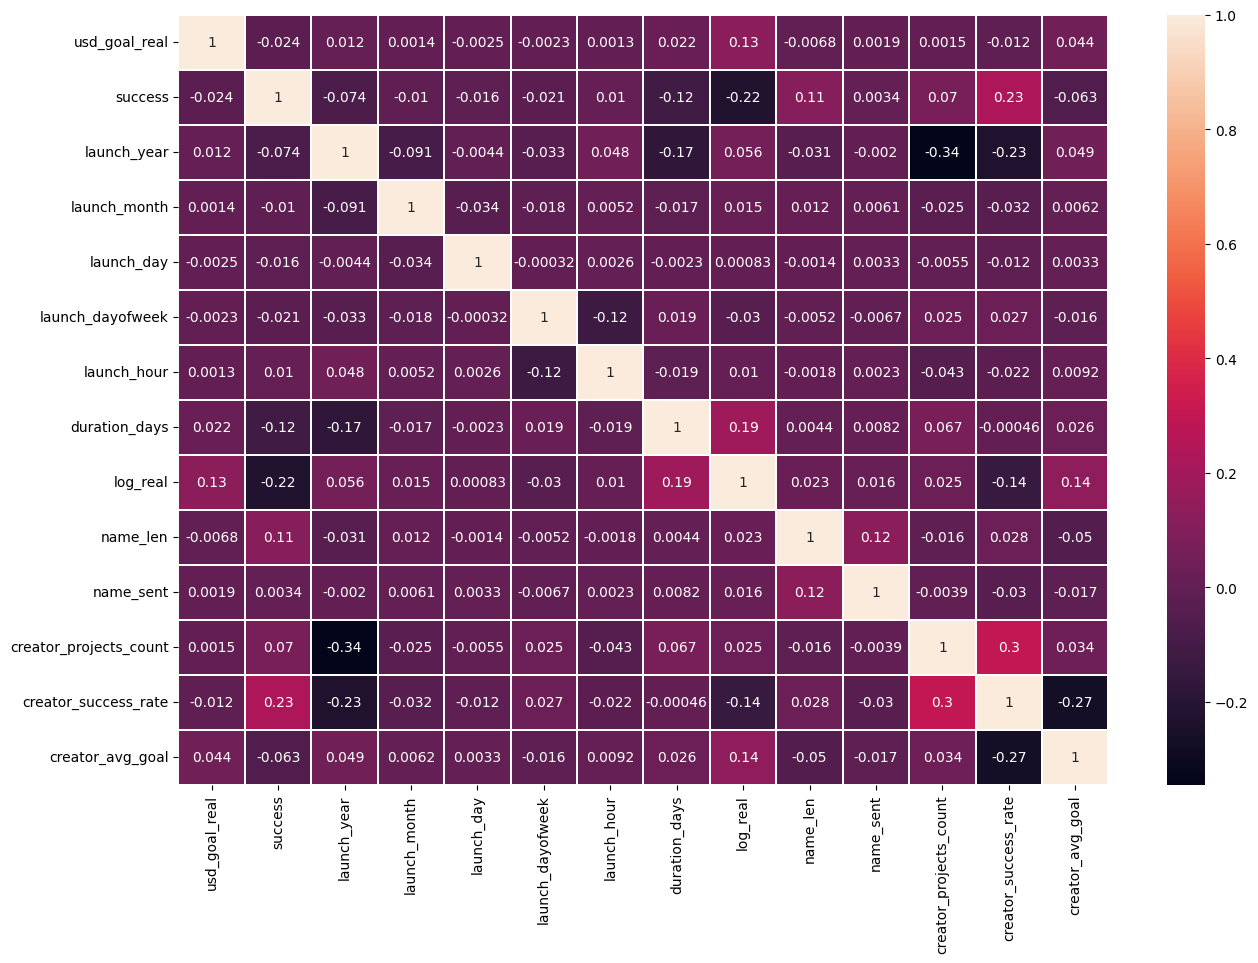

In [31]:
fig, ax = plt.subplots(figsize = (15, 10))
corr_matrix = df.corr(numeric_only = True, method = 'pearson')
sns.heatmap(corr_matrix, linewidth = 0.01, annot = True)

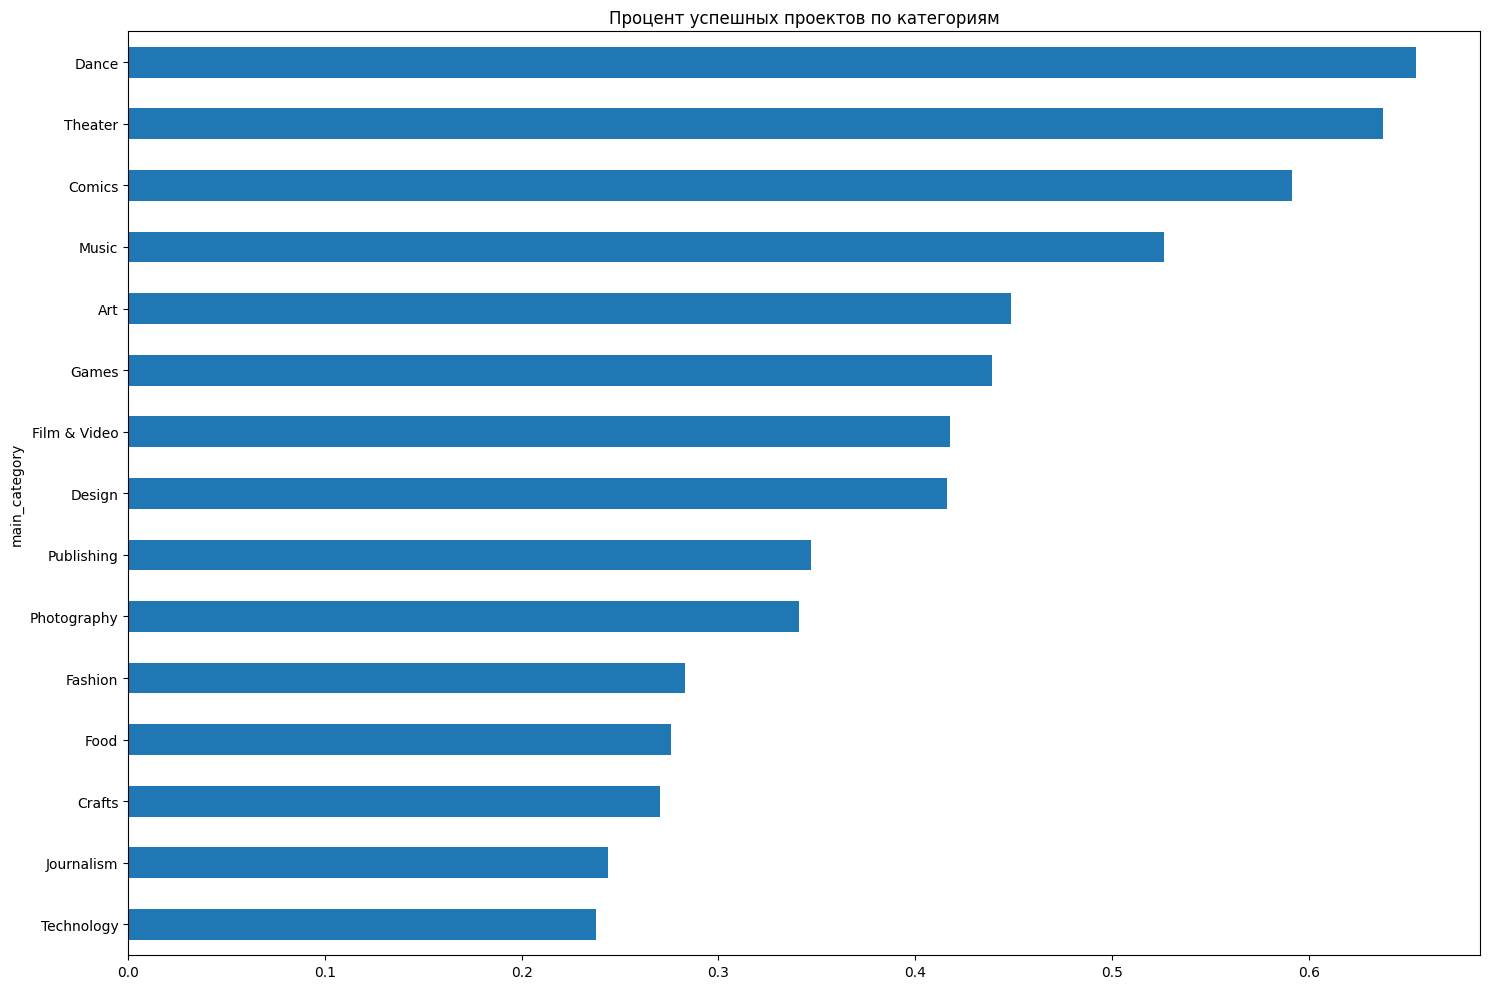

In [32]:
plt.figure(figsize = (15, 10))
cat_suc = df.groupby('main_category')['success'].mean().sort_values()
cat_suc.plot(kind = 'barh')
plt.title('Процент успешных проектов по категориям')
plt.tight_layout()
plt.show()

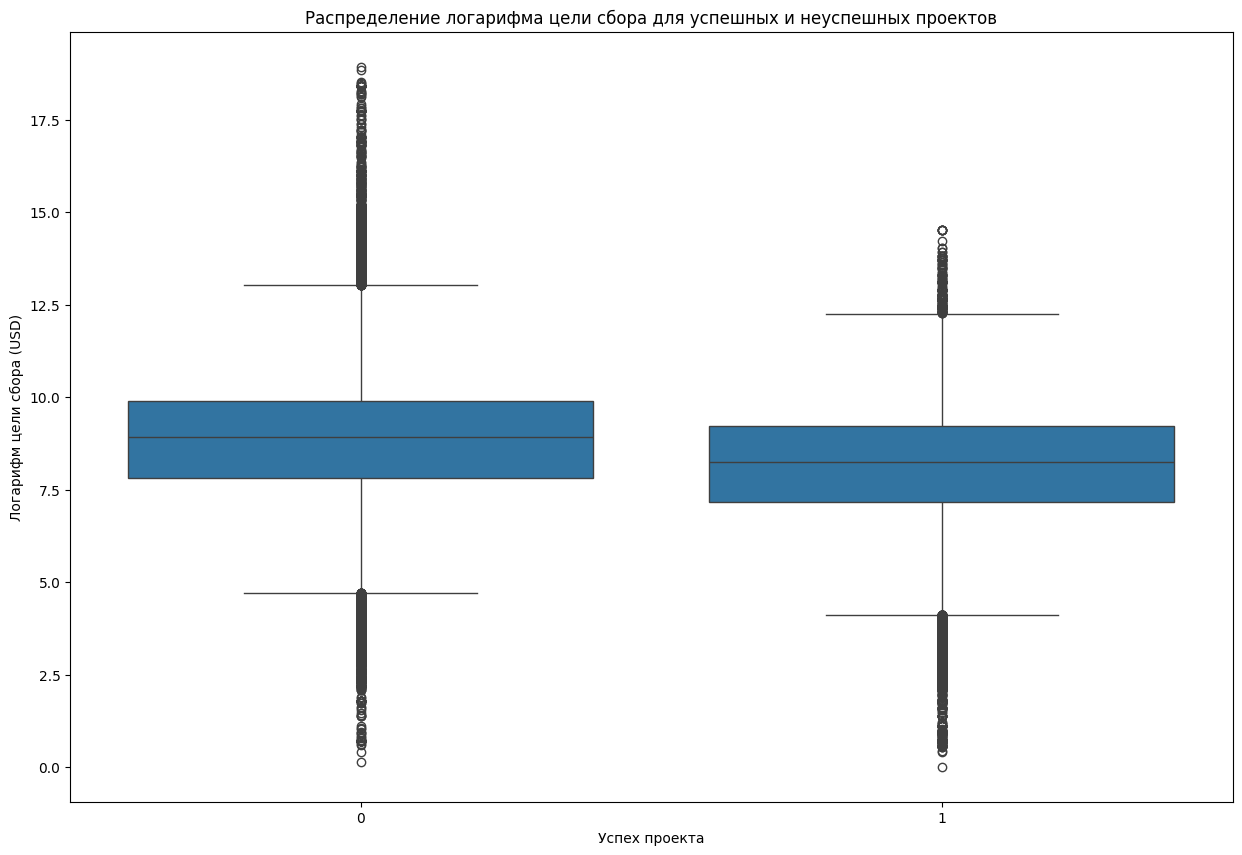

In [33]:
plt.figure(figsize = (15, 10))
sns.boxplot(x = 'success', y = 'log_real', data = df)
plt.title('Распределение логарифма цели сбора для успешных и неуспешных проектов')
plt.xlabel('Успех проекта')
plt.ylabel('Логарифм цели сбора (USD)')
plt.show()

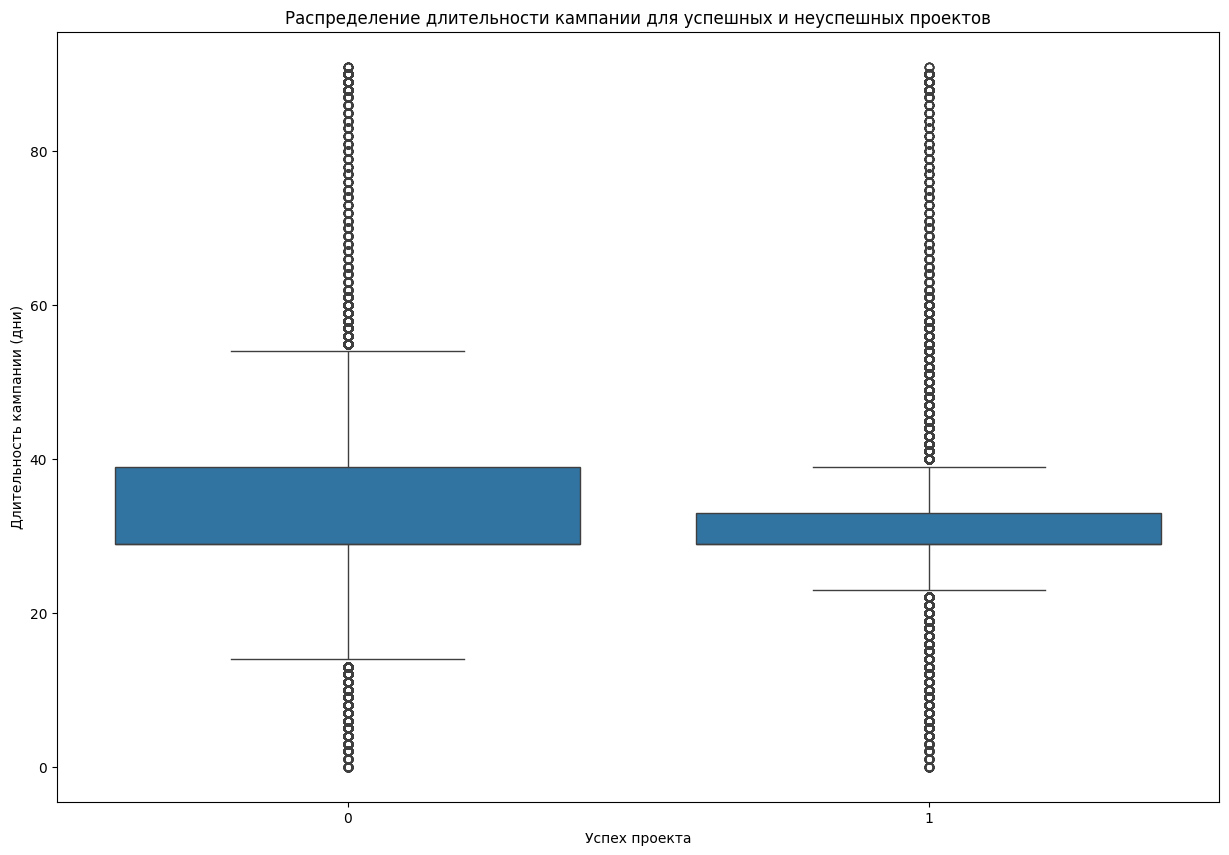

In [34]:
plt.figure(figsize = (15, 10))
sns.boxplot(x = 'success', y = 'duration_days', data = df)
plt.title('Распределение длительности кампании для успешных и неуспешных проектов')
plt.xlabel('Успех проекта')
plt.ylabel('Длительность кампании (дни)')
plt.show()

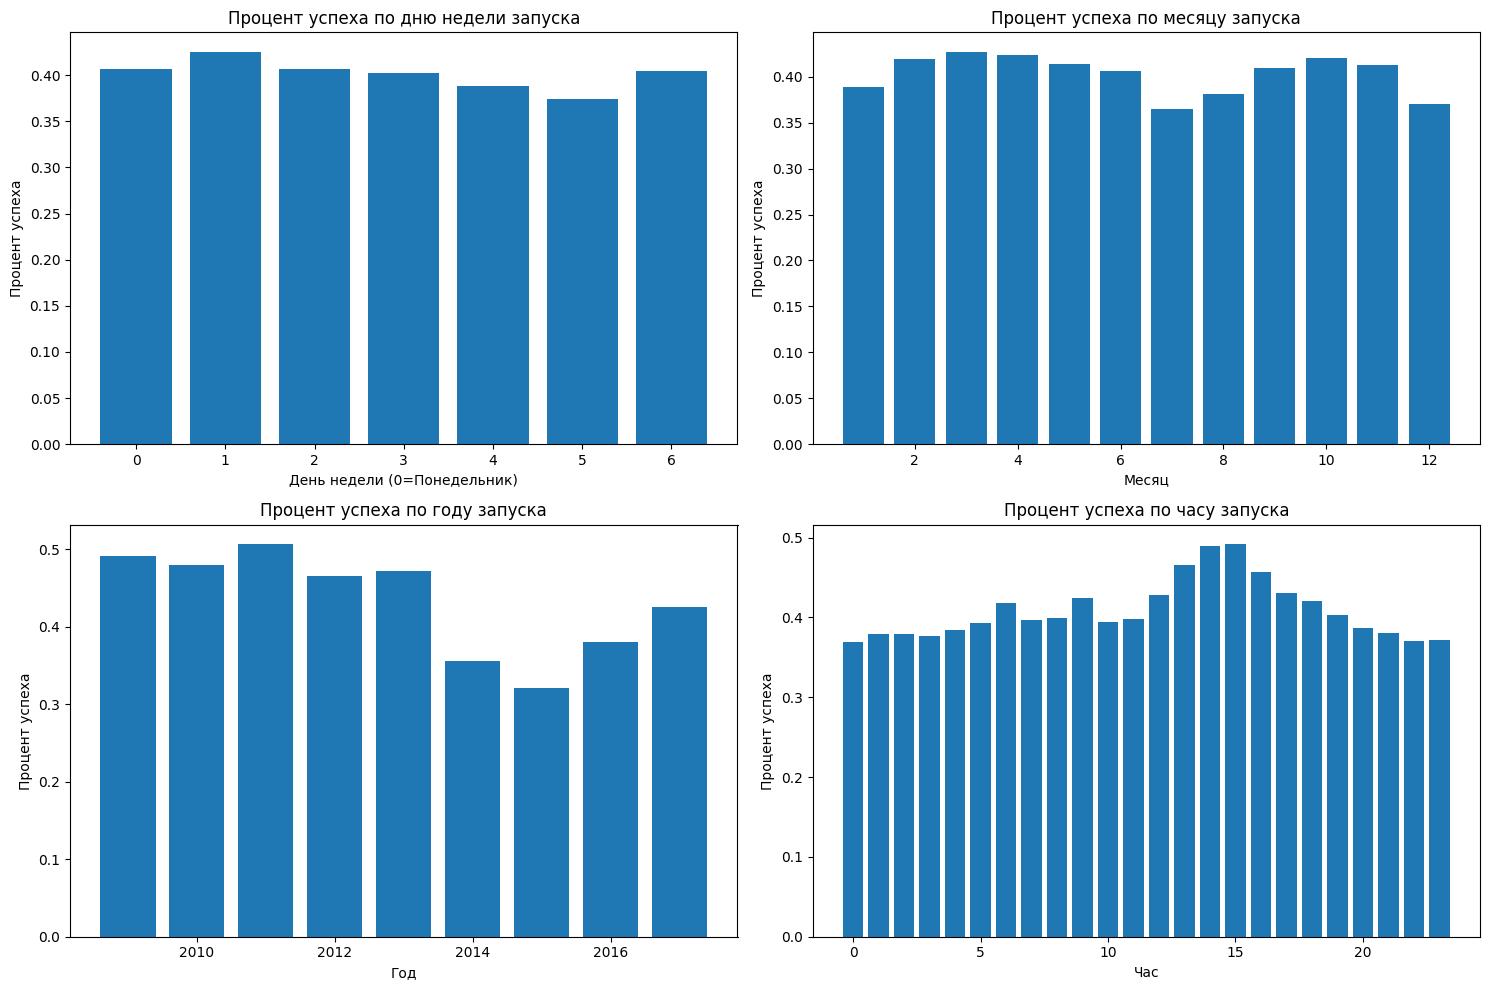

In [35]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

# День недели
day_of_week_success = df.groupby('launch_dayofweek')['success'].mean()
axes[0, 0].bar(day_of_week_success.index, day_of_week_success.values)
axes[0, 0].set_title('Процент успеха по дню недели запуска')
axes[0, 0].set_xlabel('День недели (0=Понедельник)')
axes[0, 0].set_ylabel('Процент успеха')

# Месяц
month_success = df.groupby('launch_month')['success'].mean()
axes[0, 1].bar(month_success.index, month_success.values)
axes[0, 1].set_title('Процент успеха по месяцу запуска')
axes[0, 1].set_xlabel('Месяц')
axes[0, 1].set_ylabel('Процент успеха')

# Год
year_success = df.groupby('launch_year')['success'].mean()
axes[1, 0].bar(year_success.index, year_success.values)
axes[1, 0].set_title('Процент успеха по году запуска')
axes[1, 0].set_xlabel('Год')
axes[1, 0].set_ylabel('Процент успеха')

# Час
hour_success = df.groupby('launch_hour')['success'].mean()
axes[1, 1].bar(hour_success.index, hour_success.values)
axes[1, 1].set_title('Процент успеха по часу запуска')
axes[1, 1].set_xlabel('Час')
axes[1, 1].set_ylabel('Процент успеха')

plt.tight_layout()
plt.show()

In [36]:
X = df.drop(columns = ['success'])
y = df['success']

In [37]:
numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include = ['object']).columns.tolist()
text_columns = ['name_prep']

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331675 entries, 0 to 331674
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   category                331675 non-null  object 
 1   main_category           331675 non-null  object 
 2   currency                331675 non-null  object 
 3   country                 331675 non-null  object 
 4   usd_goal_real           331675 non-null  float64
 5   success                 331675 non-null  int64  
 6   launch_year             331675 non-null  int32  
 7   launch_month            331675 non-null  int32  
 8   launch_day              331675 non-null  int32  
 9   launch_dayofweek        331675 non-null  int32  
 10  launch_hour             331675 non-null  int32  
 11  duration_days           331675 non-null  int64  
 12  log_real                331675 non-null  float64
 13  name_prep               331675 non-null  object 
 14  name_len            

In [39]:
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])
text_transformer = Pipeline(steps = [
    ('tfidf', TfidfVectorizer(max_features = 3000, stop_words='english'))
])

In [40]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_columns[0])
    ])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y)

In [42]:
X_train.shape, X_test.shape

((265340, 18), (66335, 18))

In [43]:
model = RandomForestClassifier(
    n_estimators = 100, 
    class_weight = 'balanced',
    random_state = 42
)

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6988
ROC-AUC: 0.7572

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.76     39544
           1       0.66      0.53      0.59     26791

    accuracy                           0.70     66335
   macro avg       0.69      0.67      0.67     66335
weighted avg       0.69      0.70      0.69     66335



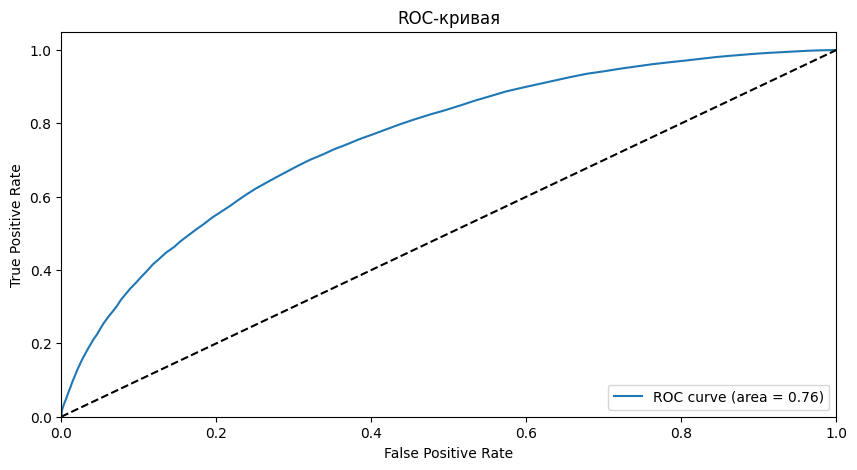

In [44]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc = "lower right")
plt.show()

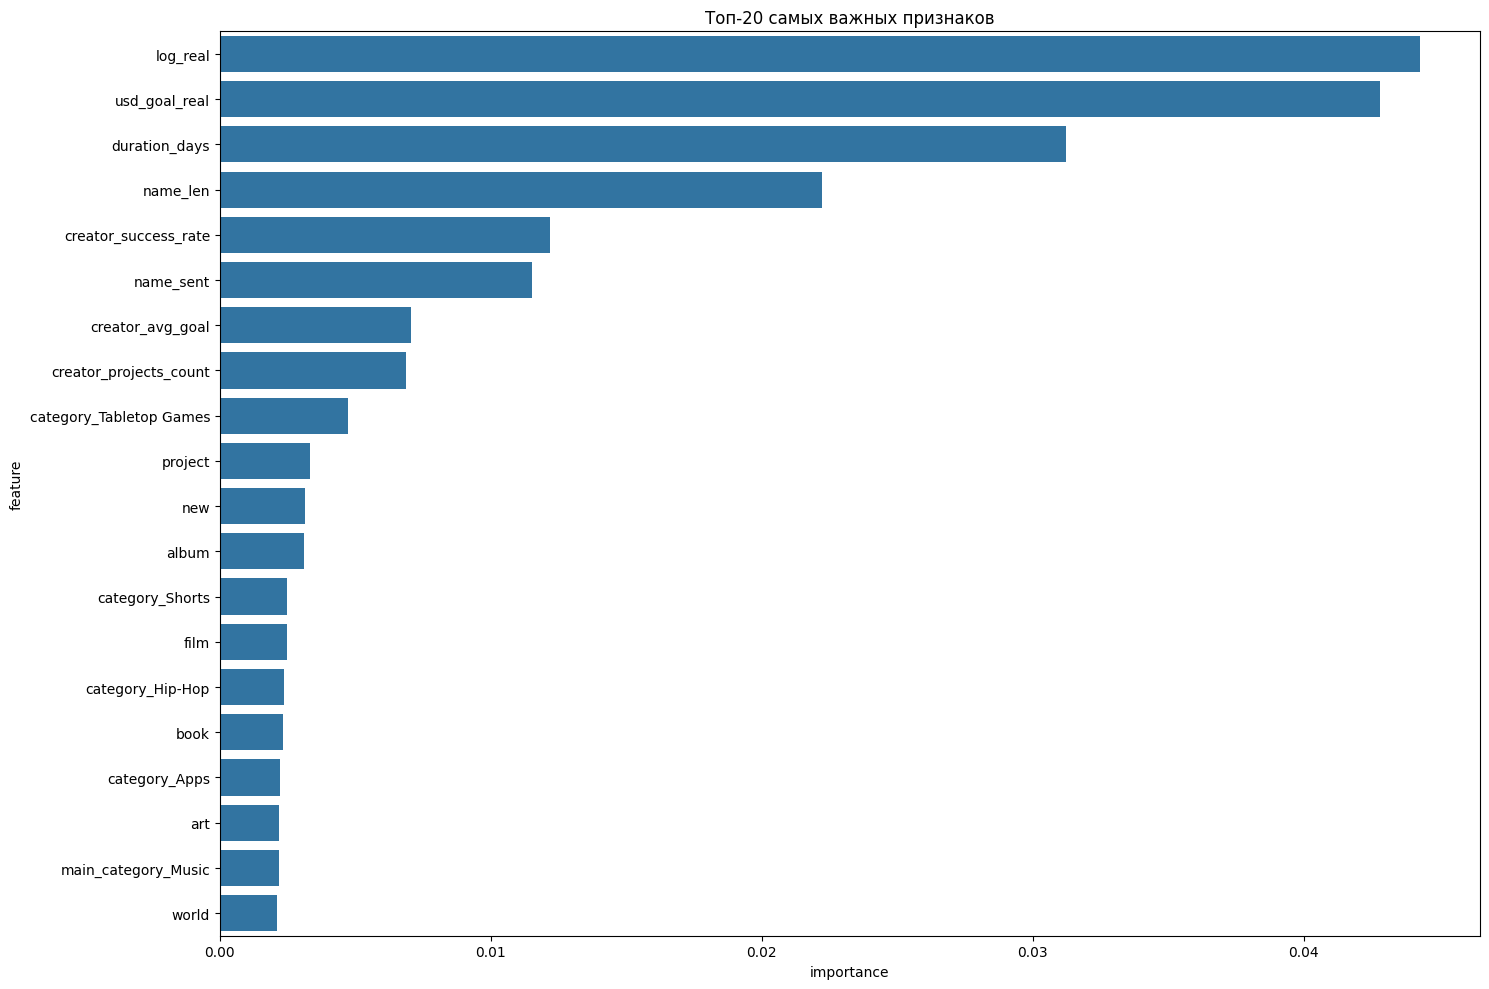

,feature,importance
2,log_real,0.044294
0,usd_goal_real,0.042806
1,duration_days,0.031223
3,name_len,0.022218
6,creator_success_rate,0.012196
4,name_sent,0.011509
7,creator_avg_goal,0.007047
5,creator_projects_count,0.006856
144,category_Tabletop Games,0.004729
260142,project,0.003322


In [45]:
feature_names = []

feature_names.extend(numeric_features)

categorical_transformer = pipeline.named_steps['preprocessor'].transformers_[1][1]
categorical_encoder = categorical_transformer.named_steps['onehot']
categorical_features = pipeline.named_steps['preprocessor'].transformers_[1][2]
categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_features)
feature_names.extend(categorical_feature_names)

text_transformer = pipeline.named_steps['preprocessor'].transformers_[2][1]
text_vectorizer = text_transformer.named_steps['tfidf']
text_feature_names = text_vectorizer.get_feature_names_out()
feature_names.extend(text_feature_names)

importances = pipeline.named_steps['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize = (15, 10))
sns.barplot(x = 'importance', y = 'feature', data = feature_importance_df.head(20))
plt.title('Топ-20 самых важных признаков')
plt.tight_layout()
plt.show()

feature_importance_df.head(10)